In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load data
df = pd.read_csv('..//data//City_Optimized.csv')

# Define columns
target = 'optimal_renewable_energy'
columns_to_drop = ['city', 'country', 'continent', 'city_id', 'latitude', 'longitude']

# Drop unwanted columns (ignore if not present)
df = df.drop(columns=columns_to_drop, axis=1, errors='ignore')

# The remaining features are all numerical (except the target)
numerical_features = df.columns.difference([target])

# Encode target (LabelEncoder is fine for the target variable)
le_target = LabelEncoder()
df[target] = le_target.fit_transform(df[target])
print("DataFrame columns:", df.columns.tolist())

# Prepare X, y
X = df[list(numerical_features)]
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train)
X_test_num = scaler.transform(X_test)

# Prepared datasets
X_train_prepared = X_train_num
X_test_prepared = X_test_num

DataFrame columns: ['solar_irradiance_avg', 'peak_sun_hours', 'avg_wind_speed', 'wind_power_density', 'annual_rainfall', 'river_proximity_score', 'hydropower_potential', 'avg_temperature', 'temperature_range', 'avg_humidity', 'cloud_cover_percentage', 'geothermal_gradient', 'population', 'population_density', 'gdp_per_capita', 'cost_of_living_index', 'avg_household_income', 'tax_revenue_per_capita', 'unemployment_rate', 'education_index', 'electricity_consumption_per_capita', 'total_electricity_consumption', 'grid_infrastructure_quality', 'current_renewable_percentage', 'fossil_fuel_dependency', 'energy_storage_capacity', 'grid_reliability_score', 'available_land_area', 'renewable_investment', 'govt_renewable_subsidy', 'rd_spending', 'transmission_infrastructure', 'carbon_emissions_per_capita', 'air_quality_index', 'environmental_policy_strength', 'renewable_target_2030', 'biomass_availability', 'urban_density_score', 'skilled_workforce_percentage', 'technology_adoption_rate', 'install

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Remove deprecated multi_class argument
param_grid_l1 = {'penalty': ['l1'], 'C': [0.1, 1, 10]}
clf_l1 = LogisticRegression(solver='saga', max_iter=2000)
grid_l1 = GridSearchCV(clf_l1, param_grid_l1, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_l1.fit(X_train_prepared, y_train)
print("Best Params (L1):", grid_l1.best_params_)

param_grid_l2 = {'penalty': ['l2'], 'C': [0.1, 1, 10]}
clf_l2 = LogisticRegression(solver='saga', max_iter=2000)
grid_l2 = GridSearchCV(clf_l2, param_grid_l2, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_l2.fit(X_train_prepared, y_train)
print("Best Params (L2):", grid_l2.best_params_)

param_grid_en = {'penalty': ['elasticnet'], 'C': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
clf_en = LogisticRegression(solver='saga', max_iter=2000)
grid_en = GridSearchCV(clf_en, param_grid_en, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_en.fit(X_train_prepared, y_train)
print("Best Params (ElasticNet):", grid_en.best_params_)

from sklearn.metrics import classification_report, accuracy_score

# Store grid search objects for each regularization
grids = [
    ('L1', grid_l1),
    ('L2', grid_l2),
    ('ElasticNet', grid_en)
]

# Compare and print results for each
results = []

for name, grid in grids:
    print(f"\n=== {name} Regularization ===")
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train_prepared)
    y_test_pred = best_model.predict(X_test_prepared)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Best Params: {grid.best_params_}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(
        y_test, y_test_pred,
        target_names=le_target.inverse_transform(np.unique(y_test))
    ))
    results.append((name, grid.best_params_, test_acc))

# Optionally, print summary to find the best on test accuracy
print("\n=== Summary ===")
for name, params, test_acc in results:
    print(f"{name}: Best Params = {params}, Test Accuracy = {test_acc:.4f}")

# Identify the best model by test accuracy
best = max(results, key=lambda x: x[2])
print(f"\nBest model: {best[0]} (Test Accuracy: {best[2]:.4f}, Params: {best[1]})")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params (L1): {'C': 1, 'penalty': 'l1'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params (L2): {'C': 1, 'penalty': 'l2'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params (ElasticNet): {'C': 1, 'l1_ratio': 0.8, 'penalty': 'elasticnet'}

=== L1 Regularization ===
Best Params: {'C': 1, 'penalty': 'l1'}
Train Accuracy: 0.8900
Test Accuracy: 0.8425
Classification Report:
              precision    recall  f1-score   support

     Biomass       0.81      0.78      0.80        92
  Geothermal       0.85      0.95      0.90        56
  Hydropower       0.84      0.64      0.73        42
       Solar       0.81      0.85      0.83       141
        Wind       0.94      0.94      0.94        69

    accuracy                           0.84       400
   macro avg       0.85      0.83      0.84       400
weighted avg       0.84      0.84      0.84       400


=== L2 Regularization ===
Best 

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Hyperparameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20, 25, 28],
    'min_samples_leaf': [1, 5, 10, 20, 25, 28],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Grid search
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_prepared, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best CV score:', grid_search.best_score_)

# Use the best estimator
clf = grid_search.best_estimator_

# 5-fold cross-validation accuracy with the best parameters
cv_scores = cross_val_score(clf, X_train_prepared, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("CV Accuracy Scores (Train):", cv_scores)
print("Mean CV Accuracy (Train):", cv_scores.mean())

# Fit model on full training data (not always needed, since grid search refits by default)
clf.fit(X_train_prepared, y_train)

# Predict and report on holdout test set
y_train_pred = clf.predict(X_train_prepared)
y_test_pred = clf.predict(X_test_prepared)

print("Train Acc:", accuracy_score(y_train, y_train_pred))
print("Test Acc:", accuracy_score(y_test, y_test_pred))

# Assuming le_target was used to encode the labels
target_names = le_target.inverse_transform(np.unique(y_test))
print(classification_report(y_test, y_test_pred, target_names=target_names))

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best CV score: 0.8225
CV Accuracy Scores (Train): [0.83125  0.8125   0.83125  0.828125 0.809375]
Mean CV Accuracy (Train): 0.8225
Train Acc: 0.883125
Test Acc: 0.805
              precision    recall  f1-score   support

     Biomass       0.74      0.85      0.79        92
  Geothermal       0.90      0.84      0.87        56
  Hydropower       0.66      0.45      0.54        42
       Solar       0.80      0.84      0.82       141
        Wind       0.91      0.87      0.89        69

    accuracy                           0.81       400
   macro avg       0.80      0.77      0.78       400
weighted avg       0.80      0.81      0.80       400



In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model_dict = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [8, 10, 12],
            'min_samples_split': [25, 30],
            'min_samples_leaf': [10, 15, 20],
            'max_features': ['sqrt', 'log2'],
        }
    }
}

# Example usage with GridSearchCV:
rf_grid = GridSearchCV(
    estimator=model_dict['Random Forest']['model'],
    param_grid=model_dict['Random Forest']['params'],
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train_prepared, y_train)

print("Best hyperparameters:", rf_grid.best_params_)
print("Best CV score:", rf_grid.best_score_)

# Optionally evaluate on test set
best_rf = rf_grid.best_estimator_
y_test_pred = best_rf.predict(X_test_prepared)
print("Train Acc:", best_rf.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_test_pred))
print(classification_report(
    y_test,
    y_test_pred,
    target_names=le_target.inverse_transform(np.unique(y_test))
))

Best hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 100}
Best CV score: 0.8350000000000002
Train Acc: 0.90375
Test Acc: 0.855
              precision    recall  f1-score   support

     Biomass       0.90      0.77      0.83        92
  Geothermal       0.90      0.95      0.92        56
  Hydropower       1.00      0.45      0.62        42
       Solar       0.79      0.94      0.86       141
        Wind       0.88      0.97      0.92        69

    accuracy                           0.85       400
   macro avg       0.89      0.82      0.83       400
weighted avg       0.87      0.85      0.85       400



In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Create a pipeline: Standardize features then apply KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Expanded grid of parameters for better search
param_grid = {
    'knn__n_neighbors': [11, 15, 21, 25, 31, 41, 51],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid.fit(X_train_prepared, y_train)

print("Best Params:", grid.best_params_)

# Evaluate on train and test sets
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_prepared)
print("Train Acc:", best_model.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_pred))

# Handle inverse transform for label names if using LabelEncoder
try:
    target_names = le_target.inverse_transform(np.unique(y_test))
except:
    target_names = None

print(classification_report(y_test, y_pred, target_names=target_names))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Params: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
Train Acc: 0.765625
Test Acc: 0.6875
              precision    recall  f1-score   support

     Biomass       0.75      0.48      0.58        92
  Geothermal       0.97      0.70      0.81        56
  Hydropower       0.61      0.33      0.43        42
       Solar       0.58      0.91      0.71       141
        Wind       0.86      0.71      0.78        69

    accuracy                           0.69       400
   macro avg       0.75      0.63      0.66       400
weighted avg       0.73      0.69      0.68       400



In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_prepared, y_train)
y_pred = clf.predict(X_test_prepared)
print("Train Acc:", clf.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_target.inverse_transform(np.unique(y_test))))

Train Acc: 0.714375
Test Acc: 0.7275
              precision    recall  f1-score   support

     Biomass       0.78      0.46      0.58        92
  Geothermal       0.80      0.80      0.80        56
  Hydropower       0.60      0.62      0.61        42
       Solar       0.64      0.82      0.72       141
        Wind       0.93      0.90      0.91        69

    accuracy                           0.73       400
   macro avg       0.75      0.72      0.73       400
weighted avg       0.74      0.73      0.72       400



In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. Define parameter grids for each kernel
param_grid_linear = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],            # 5 C values
    "kernel": ["linear"],
    "class_weight": [None, "balanced"]        # 2 options
}

param_grid_rbf = {
    "C": [0.01, 0.1, 1, 10, 100],                  # 4 C values
    "kernel": ["rbf"],
    "gamma": ["scale", "auto", 0.1, 0.01],   # 4 gamma values
    "class_weight": [None, "balanced"]        # 2 options
}

param_grid_poly = {
    "C": [0.01,0.1, 1, 10],                       # 3 C values
    "kernel": ["poly"],
    "degree": [2, 3, 4],                     # 3 degree values
    "gamma": ["scale", "auto", 0.01],        # 3 gamma values
    "coef0": [0.0, 0.1, 0.5],                # 3 coef0 values
    "class_weight": ["balanced"]              # 1 option (often best for 'poly')
}

# 2. Combine results of each grid search
grids = []
for param_grid in [param_grid_linear, param_grid_rbf, param_grid_poly]:
    grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train_prepared, y_train)
    grids.append(grid)

# 3. Find the best overall
best_score = -1
best_clf = None
best_params = None
for grid in grids:
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_clf = grid.best_estimator_
        best_params = grid.best_params_

print("Best Params:", best_params)

# 4. Evaluate on test set
y_pred = best_clf.predict(X_test_prepared)
print("Train Acc:", best_clf.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_target.inverse_transform(np.unique(y_test))))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'C': 1, 'class_weight': None, 'kernel': 'linear'}
Train Acc: 0.911875
Test Acc: 0.82
              precision    recall  f1-score   support

     Biomass       0.80      0.78      0.79        92
  Geothermal       0.84      0.86      0.85        56
  Hydropower       0.68      0.67      0.67        42
       Solar       0.81      0.83      0.82       141
        Wind       0.93      0.91      0.92        69

    accuracy                           0.82       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.82      0.82      0.82       400



In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Expanded AdaBoost-only hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0]
}

clf = AdaBoostClassifier()  # This uses DecisionTree(max_depth=1) by default

# Grid search with cross-validation
grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_prepared, y_train)

# Output results
print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_prepared)

print("Train Acc:", best_model.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_pred))
print(classification_report(
    y_test,
    y_pred,
    target_names=le_target.inverse_transform(np.unique(y_test))
))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'learning_rate': 1.5, 'n_estimators': 200}
Train Acc: 0.874375
Test Acc: 0.86
              precision    recall  f1-score   support

     Biomass       0.84      0.82      0.83        92
  Geothermal       0.86      0.96      0.91        56
  Hydropower       0.82      0.74      0.78        42
       Solar       0.86      0.85      0.85       141
        Wind       0.91      0.93      0.92        69

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define a more comprehensive hyperparameter grid
param_grid = {
    'n_estimators': [100],              # keep at 100 (standard or tune later)
    'max_depth': [3, 5],                # retain just two,
    'learning_rate': [0.05, 0.1],       # the two most common rates
    'subsample': [1.0],                 # full sample only
    'min_samples_split': [2, 5],        # standard, less variation
    'min_samples_leaf': [1, 3]          # just two options
}

clf = GradientBoostingClassifier()

grid = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_prepared, y_train)
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_prepared)
print("Train Acc:", best_model.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_target.inverse_transform(np.unique(y_test))))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Best Score: 0.8975
Train Acc: 1.0
Test Acc: 0.885
              precision    recall  f1-score   support

     Biomass       0.90      0.85      0.87        92
  Geothermal       0.90      0.95      0.92        56
  Hydropower       0.93      0.62      0.74        42
       Solar       0.83      0.93      0.88       141
        Wind       0.96      0.96      0.96        69

    accuracy                           0.89       400
   macro avg       0.90      0.86      0.87       400
weighted avg       0.89      0.89      0.88       400



In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [ 100, 150], 
              'max_depth': [3, 6, 8],
              'learning_rate': [0.01, 0.1, 0.2],
              'subsample': [0.8, 1.0],
}
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_prepared, y_train)
print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_prepared)
print("Train Acc:", best_model.score(X_train_prepared, y_train))
print("Test Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_target.inverse_transform(np.unique(y_test))))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\aayus\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:02:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
Train Acc: 1.0
Test Acc: 0.9025
              precision    recall  f1-score   support

     Biomass       0.90      0.86      0.88        92
  Geothermal       0.93      0.98      0.96        56
  Hydropower       1.00      0.64      0.78        42
       Solar       0.87      0.96      0.91       141
        Wind       0.93      0.94      0.94        69

    accuracy                           0.90       400
   macro avg       0.92      0.88      0.89       400
weighted avg       0.91      0.90      0.90       400



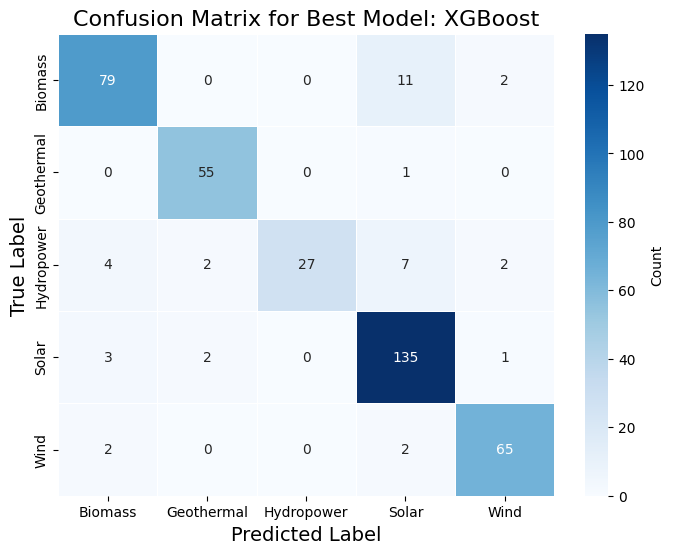

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Assuming the fitted XGBoost GridSearchCV object is the last object stored in 'grid'
best_xgb_model = grid.best_estimator_
y_pred = best_xgb_model.predict(X_test_prepared)

# Get the unique, inverse-transformed target names
target_names = le_target.inverse_transform(np.unique(y_test))

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix for Best Model: XGBoost', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

C:\Users\aayus\AppData\Local\Temp\ipykernel_18872\714794722.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Spectral', n_classes) # Get distinct colors


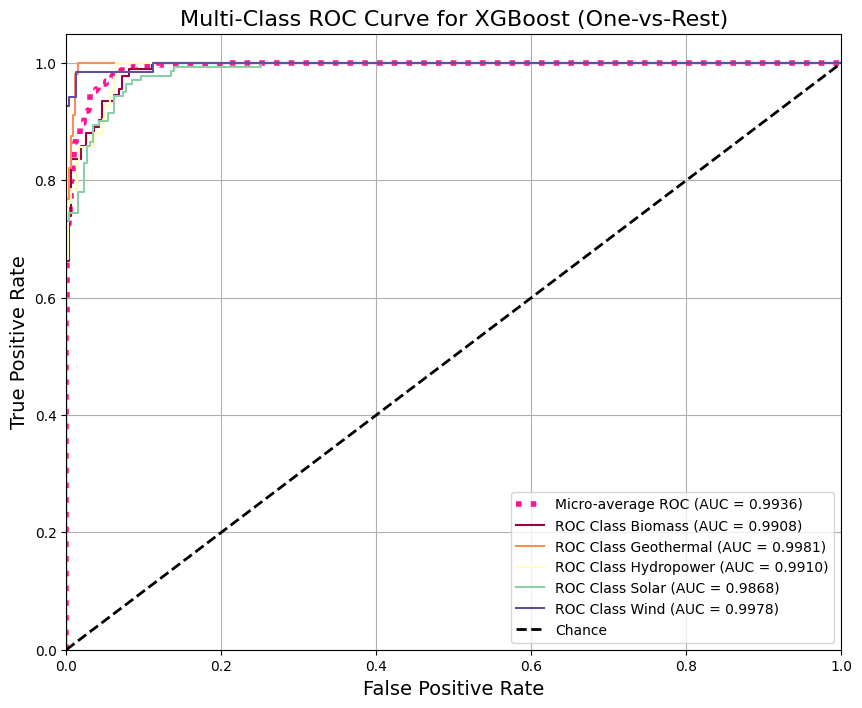

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_xgb_model is the fitted XGBClassifier
# Binarize the output labels (required for multi-class ROC)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_binarized.shape[1]

# Predict probabilities
y_proba = best_xgb_model.predict_proba(X_test_prepared)

# Calculate ROC curve and AUC for each class (OvR)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))

# Plot micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot each class ROC
target_names = le_target.inverse_transform(np.unique(y_test))
colors = plt.cm.get_cmap('Spectral', n_classes) # Get distinct colors

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC Class {target_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curve for XGBoost (One-vs-Rest)', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

C:\Users\aayus\AppData\Local\Temp\ipykernel_18872\2068020380.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='mako')


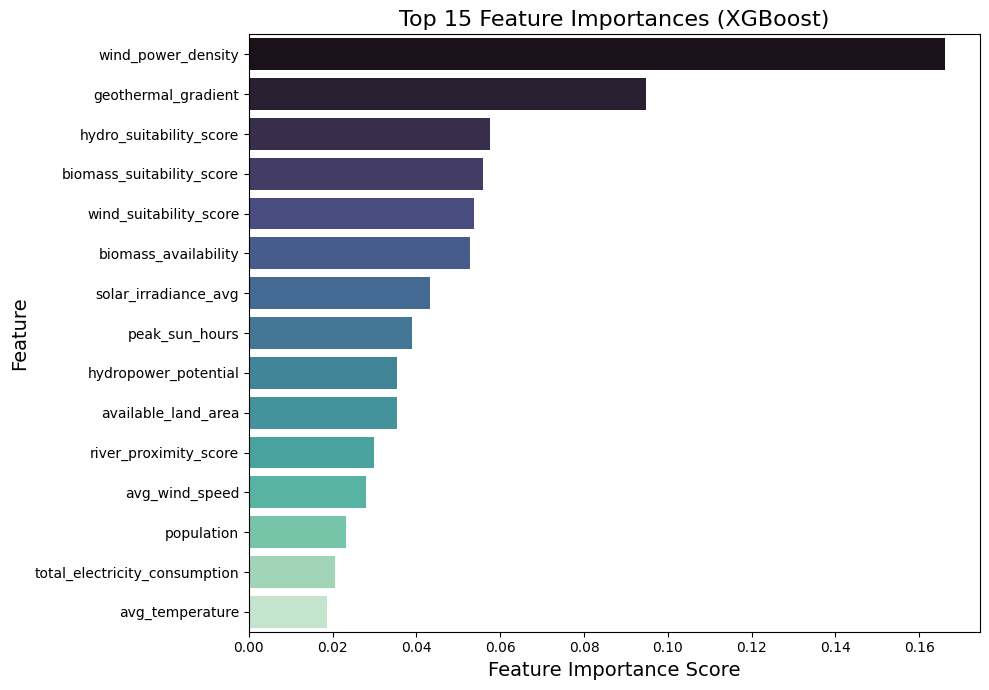

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'best_xgb_model' is the fitted XGBClassifier
# and 'X' is your original feature DataFrame used before scaling

# Get feature importances from the fitted model
importances = best_xgb_model.feature_importances_

# Create a DataFrame for easy plotting
feature_names = X.columns # Use the original column names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the top features
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='mako')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()